In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

**Getting CelebA Data using Kaggle API**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shri0007j","key":"af752b02d5a824e4ca0b2cc5964c1f61"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:20<00:00, 49.9MB/s]
100% 1.33G/1.33G [00:21<00:00, 67.9MB/s]


In [5]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [6]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

**Import required Libraries**

In [7]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

In [8]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599


INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 2 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Total number of images : 202599
Found 202599 images belonging to 1 classes.


**Encoder with Sampling**

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
latent_dim = 200
#import keras as k
def encoder():
  encoder_inputs = keras.Input(shape=(128, 128, 3))
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  shape_before_flat = K.int_shape(x)[1:] 
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder_model = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  return encoder_inputs, z_mean, z_log_var, z, shape_before_flat, encoder_model

In [11]:
encoder_inputs, z_mean, z_log_var, z, shape_before_flat,  encoder_model = encoder()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**Decoder**

In [12]:
def decoder(latent_dim):
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
  x = layers.Reshape((16, 16, 64))(x)
  x = layers.Conv2DTranspose(64, 2, activation="relu", strides=2, padding="same")(x)
  #x = layers.Conv2DTranspose(32, 2, activation="relu", strides=1, padding="same")(x)
  x = layers.Conv2DTranspose(32, 2, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 2, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
  decoder_model = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  return latent_inputs, decoder_outputs, decoder_model

In [13]:
latent_inputs, decoder_outputs, decoder_model = decoder(latent_dim = 200)

**Connect Encoded image to decoder**

In [14]:
# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_encoder_input = encoder_inputs
decoder_input = z
vae_output = decoder_model(decoder_input)
vae_model = keras.Model(simple_encoder_input, vae_output)

**Loss Function and Training**

In [15]:
LEARNING_RATE = 0.0005
N_EPOCHS = 50 
LOSS_FACTOR = 10000

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = 1)
    return 0.0001*kl_loss  #to avoid creating same image due to imbalance in loss

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)
                        #callbacks=[checkpoint_vae])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
396/395 [==============================] - 230s 580ms/step - loss: 469.3454 - r_loss: 0.0469 - kl_loss: 0.2336
Epoch 2/50
396/395 [==============================] - 224s 566ms/step - loss: 339.3568 - r_loss: 0.0339 - kl_loss: 0.1555
Epoch 3/50
396/395 [==============================] - 223s 564ms/step - loss: 329.1605 - r_loss: 0.0329 - kl_loss: 0.0995
Epoch 4/50
396/395 [==============================] - 224s 565ms/step - loss: 324.7868 - r_loss: 0.0325 - kl_loss: 0.0872
Epoch 5/50
396/395 [==============================] - 223s 564ms/step - loss: 322.1857 - r_loss: 0.0322 - kl_loss: 0.0834
Epoch 6/50
396/395 [==============================] - 223s 562ms/step - loss: 320.5579 - r_loss: 0.0320 - kl_loss: 0.0819
Epoch 7/50
396/395 [==============================] - 222s 561ms/step - loss: 319.2565 - r_loss: 0.0319 - kl_loss: 0.0819
Epoch 8/50
396/395 [==============================] - 223s 562ms/step 

**Visualization**

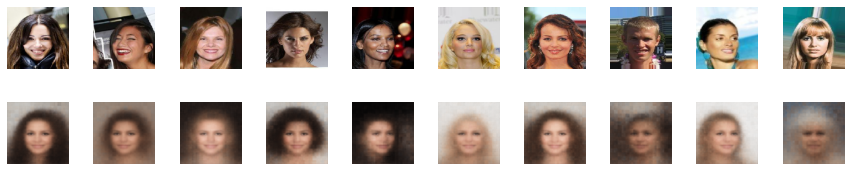

In [16]:
import matplotlib.pyplot as plt

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

plot_compare_vae(images = example_images) 